======================================================================
# Udacity Datascience Nano Degree Project #1
======================================================================
## In this project, I will be using the Seattle Airbnb Open Dataset
## I will try to answer three questions, every question is targeted to benefit a different customer. 
====
### Q1) As a real-estate company that sells houses in Seatle, where should I focus my marketing campaigns ? Assume we have a budget for campaigns in 10 different locations. 
====
### Q2) As a place owner in seattle, which renting model should I use to maximize my average profit ? 
#### Q2.a) Should I rent entire place ? rent individual rooms? rent shared rooms ?
#### Q2.b) Should I optmize the price for nightly stay ? weekly stay? monthly stay?
#### Q3.c) Should I allow free cancellation  ?
====
### Q3) As a tourist  who travels alone with low budget and flexibility of free time, which month of the year would be cheapest for me to have a vacation in Seatle ? Also which neighbourhood should I target if I am not so picky ?
====

In [340]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
calendar = pd.read_csv("./calendar.csv")
listings = pd.read_csv("./listings.csv")
reviews = pd.read_csv("./reviews.csv")

In [341]:
print(listings.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [342]:
print(reviews.columns)

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')


In [343]:
print(calendar.columns)

Index(['listing_id', 'date', 'available', 'price'], dtype='object')


# Question 1  : As a real-estate company that sells houses in Seatle, where should I focus my marketing campaigns ? Assume we have a budget for campaigns in 10 different locations.

In [358]:
# drop listings where host location is not available.
listings_temp = listings.dropna(subset=["host_location"])
# Group listings by `host_location`, count, and sort
data = listings_temp.groupby('host_location').count()['id'].reset_index(name='count').sort_values(['count'], ascending=False)



Let's draw a histogram of the data

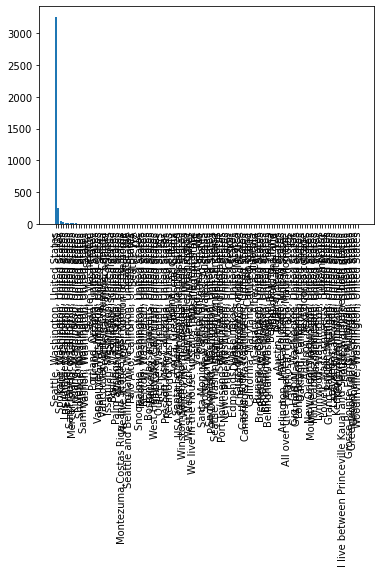

In [359]:
plt.bar(data['host_location'], data['count'])
plt.xticks(rotation='vertical')
plt.show()

This histogram does not seem that useful. Let's try to analyze the data a little bit more 

In [360]:
data.describe()

count
count   120.000000
mean     31.750000
std     297.954998
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max    3259.000000

It looks like more than 50% of the host_locations are repeated only time.  Let's ignore those 

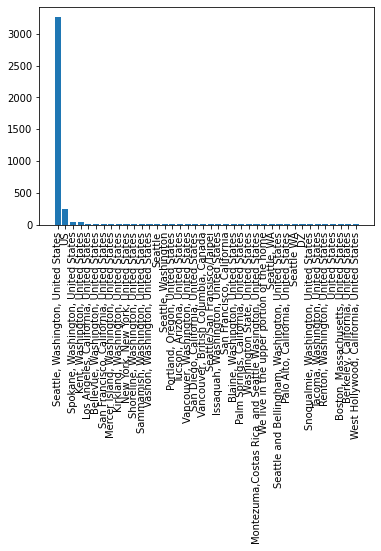

In [361]:
data_count_more_than_one = data[data['count'] > 1].reset_index(drop=True)
plt.bar(data_count_more_than_one['host_location'], data_count_more_than_one['count'])
plt.xticks(rotation='vertical')
plt.show()

Looks better. Now it seems that the most repeated value is Seatle itself, and by a large margin. The second most repeated value is `US` which is still not that useful. Let's remove those two values for better visibility.

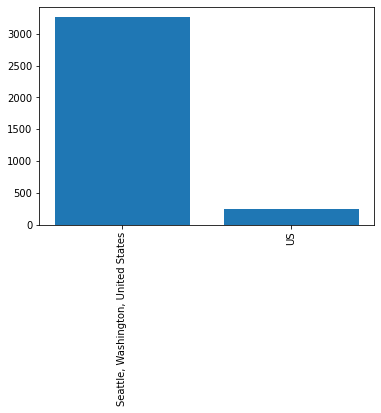

In [365]:
data_temp = data_count_more_than_one.loc[0:1]
plt.bar(data_temp['host_location'], data_temp['count'])
plt.xticks(rotation='vertical')
plt.show()

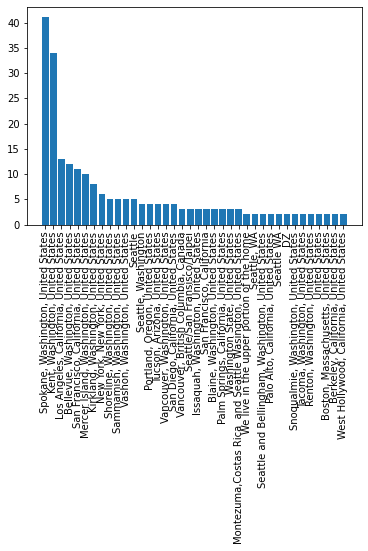

In [366]:
data_temp = data_count_more_than_one.loc[2:]
plt.bar(data_temp['host_location'], data_temp['count'])
plt.xticks(rotation='vertical')
plt.show()

Looking at this histogram, it looks like the distribution decays very quickly, and it is easy to make a decision on the best 9 locations to target with a marketing campagin, in addition to Seatle itself. This will get us to the required 10 most promising locations. We could also guide how many ads should be targetted at each of the top 10 locations. 


In [403]:
data_count_more_than_one['importance'] = 100 * data_count_more_than_one['count']/data_count_more_than_one['count'].sum()

In [404]:
recommended_places = pd.concat([data_count_more_than_one.loc[0:0],
                                data_count_more_than_one.loc[2:10]], axis=0)
recommended_places

host_location  count  importance
0         Seattle, Washington, United States   3259   87.372654
2         Spokane, Washington, United States     41    1.099196
3            Kent, Washington, United States     34    0.911528
4     Los Angeles, California, United States     13    0.348525
5        Bellevue, Washington, United States     12    0.321716
6   San Francisco, California, United States     11    0.294906
7   Mercer Island, Washington, United States     10    0.268097
8        Kirkland, Washington, United States      8    0.214477
9          New York, New York, United States      6    0.160858
10      Shoreline, Washington, United States      5    0.134048

87.37% of the marketing effort should be targeted inside seatle itself ! 
What about the remaining 12.73% of the marketing effort ?

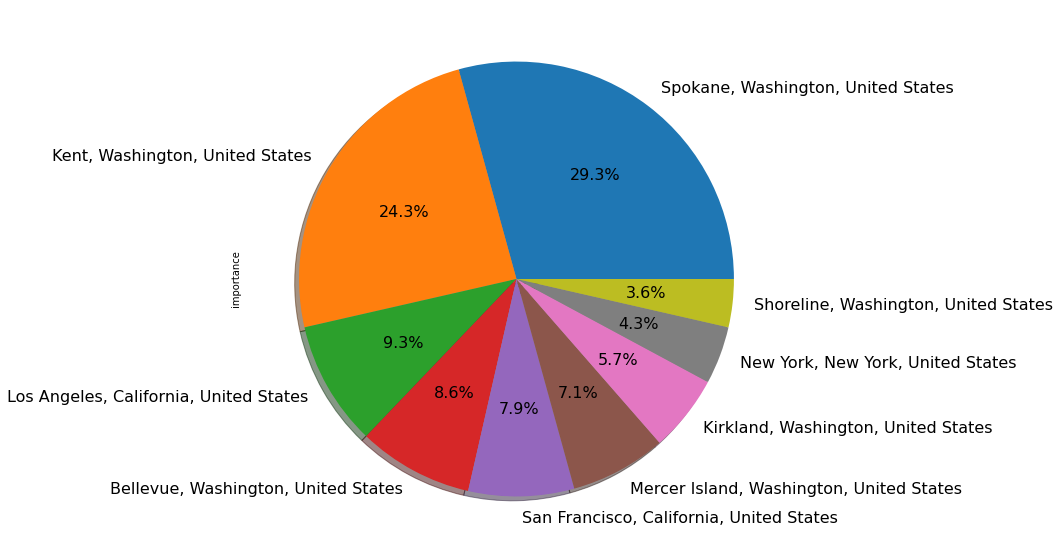

In [419]:
recommended_places_minus_seatle = recommended_places.loc[1:].set_index("host_location")
plot = recommended_places_minus_seatle.plot.pie( y='importance', figsize=(10,10), 
                                                legend=False, autopct='%1.1f%%',
                                               shadow=True,
                                               textprops={'fontsize': 16})

# This Pie Chart should be delivered to the real estate company ! 
## Final Recommendation (Answer To Question 1) : 
### (1) Spend 87.37 of your marketing effort in Seatle
### (2) Distribute the remaining 12.73% of effort accourding to the provided pie chart.

# =================================================

# Question 2

# Q2) As a place owner in seattle, which renting model should I use to maximize my average profit ? 
#### Q2.a) Should I rent entire place ? rent individual rooms? rent shared rooms ?
#### Q2.b) Should I optmize the price for nightly stay ? weekly stay? monthly stay?
#### Q3.c) Should I allow free cancellation  ?

# Answer : I really wanted to answer this question, and it is a very relevant business need .. However, I believe the data we currently have is not sufficient to answer this question. We do NOT have information whether every listing is reserved (thus, making profit) at a specific date or not.
### I first thought that the  `availability` attribute could be interpreted to answer this question. i.e, if the place is not "available", then it is currently rented and making profit. This seems like a long shot, though, cause the host might simply have chosen to not list this place at all at those specific dates ! 

### I also thought : Can I just assume that all types of rooms [entire_place/private_room/shared_room] are reserved at all times where they are listed as available ? This again seemed like a very long shot, and I would say the analysis based on such assumption are not gonna be reliable. 

### The situation gets worse for nightly vs weekly vs monthly stay price optimization. Again, I need information on the distribution of reservation patterns. i.e : Was a specific place type mostly reserved weekly or monthly ? Again, we don't have such information, and we can't make a decision here.  

### Same issues applies to the effect of free cancellation on people's willingness to reserve the place. Also we have no information on how many places with free cancellation were reserved only to have the free cancellation option used, causing the host to lose money.

## In a real-world scenario, my ask here would be to explicitly get this data before making a recommendation for a new investor.

# =============================================================
# Q3) As a tourist who travels alone with low budget and flexibility of free time, (a) which month of the year would be cheapest for me to have a vacation in Seatle ? Also (b) which neighbourhood should I target if I am not so picky ?

## To answer part (a), we need to filter the data to only the places that accommodate a single person. After that, get the average pricing by month, and choose the month with the smallest average price.

In [685]:
calendar_temp = calendar.copy()
# drop days where a price is not available (This correlates with the `availability` attribute)
calendar_temp.dropna(subset=['price'], inplace=True)
# Extract the month from the date
calendar_temp['month'] = calendar_temp['date'].apply(lambda date: int(str(date).split("-")[1]))
calendar_temp['price_float'] = calendar_temp['price'].apply(lambda s: float(str(s).replace("$", "").replace(",", "")))
# filter non-needed attributes
calendar_temp = calendar_temp[['listing_id', 'month', 'price_float']]
# join listings and calendar tables to get accomodation and neighbourhood information
listings_neighbourhood_accommodates = listings[['id', 'neighbourhood_group_cleansed', 'accommodates']]
calendar_temp = pd.merge(calendar_temp, listings_neighbourhood_accommodates, left_on='listing_id', right_on='id', how='left')
# Remove listings that accommodate more than one person
calendar_temp = calendar_temp[calendar_temp['accommodates'] == 1]
# Calculate the mean price for every combination of (month, neighbourhood)
agg_month_neighbourhood = calendar_temp.groupby(["month", 'neighbourhood_group_cleansed'])['price_float'].agg(['count','mean'])
agg_month_neighbourhood.head(1000)

count        mean
month neighbourhood_group_cleansed                   
1     Ballard                         126   54.238095
      Beacon Hill                     319   48.664577
      Capitol Hill                   1042   53.042226
      Cascade                          47   86.872340
      Central Area                    190   63.531579
      Delridge                         54   65.333333
      Downtown                        267   83.936330
      Interbay                         60   93.433333
      Lake City                       172   69.953488
      Magnolia                         72   36.652778
      Northgate                        93   46.333333
      Other neighborhoods            1480   52.875676
      Queen Anne                      181   81.237569
      Rainier Valley                  186   50.349462
      University District             413   54.353511
      West Seattle                    127   64.779528
2     Ballard                         144   53.090278
      Beacon Hill                     361   46.819945
      Capitol Hill                   1232   51.915584
      Cascade                          29  100.000000
      Central Area                    208   55.485577
      Delridge                         58   63.500000
      Downtown                        311   93.353698
      Interbay                         58   93.465517
      Lake City                       159   76.169811
      Magnolia                         87   42.517241
      Northgate                        91   45.923077
      Other neighborhoods            1698   52.252061
      Queen Anne                      170   80.470588
      Rainier Valley                  214   49.098131
      University District             376   51.680851
      West Seattle                    163   59.128834
3     Ballard                         186   52.833333
      Beacon Hill                     369   45.737127
      Capitol Hill                   1409   53.363378
      Cascade                          31  100.000000
      Central Area                    270   57.877778
      Delridge                         62   63.500000
      Downtown                        389   90.385604
      Interbay                         62   93.403226
      Lake City                       244   66.602459
      Magnolia                         72   45.763889
      Northgate                       124   44.000000
      Other neighborhoods            1867   51.831280
      Queen Anne                      186   81.075269
      Rainier Valley                  240   48.454167
      University District             398   52.047739
      West Seattle                    171   59.485380
4     Ballard                         151   53.377483
      Beacon Hill                     255   44.949020
      Capitol Hill                   1387   55.717376
      Cascade                          30  100.000000
      Central Area                    155   55.451613
      Delridge                         60   63.500000
      Downtown                        416   89.706731
      Interbay                         60   93.666667
      Lake City                       240   62.258333
      Magnolia                         61   47.590164
      Northgate                       120   43.916667
      Other neighborhoods            1618   52.968480
      Queen Anne                      151   80.695364
      Rainier Valley                  239   47.276151
      University District             338   53.103550
      West Seattle                    151   62.311258
5     Ballard                         155   53.400000
      Beacon Hill                     295   49.559322
      Capitol Hill                   1519   57.077683
      Cascade                          31  100.000000
      Central Area                    186   69.623656
      Delridge                         62   63.500000
      Downtown                        434   89.919355
      Interbay                         62   93.403226
      Lake City                       24

## Let's plot a graph to summatize this dataframe. 
### For every neighbourhood, plot the mean value per month 

In [714]:
from typing import List
def plot_avg_price_per_month_per_neighbourhood(df : pd.DataFrame, neighbourhoods: List[str] = None):
    """
     Given a dataframe `df`, This function plots the average price per neighbourhood per month.
        Args:
        df : Dataframe having `month`, `neighbourhood_group_cleansed`, and `mean` columns
        neighbourhoods : A list of neighbourhoods we care about. 
                         If None is passed, all the neighbourhoods in the dataframe are used.
    """
    if neighbourhoods is None:
        neighbourhoods = df["neighbourhood_group_cleansed"].unique()
    fig = plt.figure(figsize=(10,15))
    ax = plt.subplot()

    for n in neighbourhoods:
        df_neigh = df[df["neighbourhood_group_cleansed"] == n]
        means = df_neigh["mean"]
        months = df_neigh["month"]
        ax.plot(months, means, label=n)


    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.ylabel('Average price ($)')
    plt.xlabel('Neighbourhood')
    plt.title('Average price per neighbourhood per month ($)')
    plt.xticks(list(range(1,13)), rotation='horizontal')

    plt.show()
    

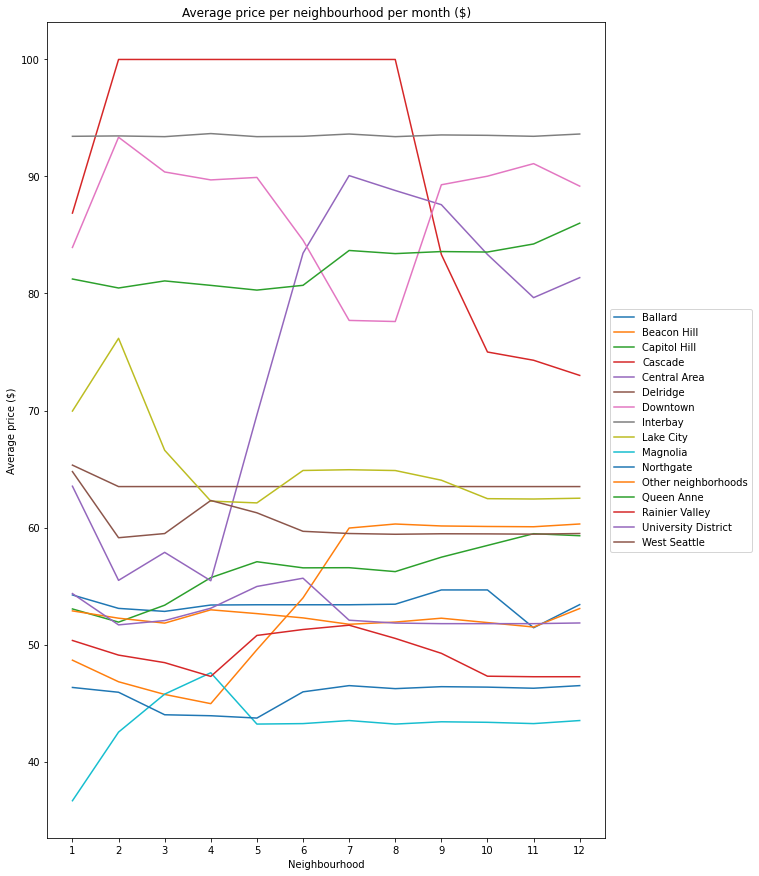

In [715]:
df = agg_month_neighbourhood.reset_index()
plot_avg_price_per_month_per_neighbourhood(df=df)

## While we could probably infer useful information from this graph, There are too many colors and too many lines. 

## Let's filter the dataframe and only include neighbourhoods that happen to be the cheapest in any given month [Even if it is still very high in other months]. 

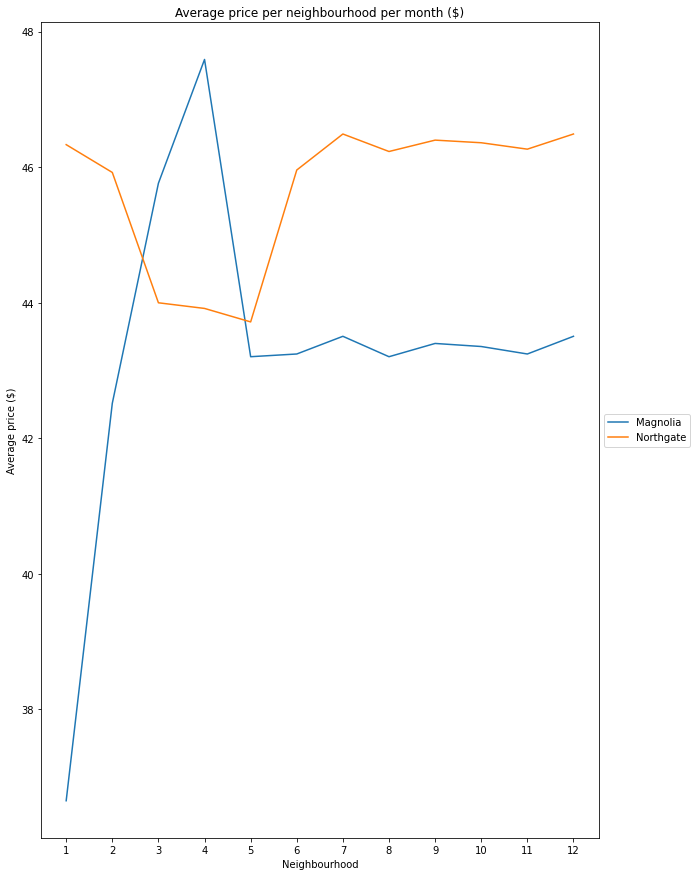

In [717]:
nsmallest_required = 1
agg_month_neighbourhood_subset = agg_month_neighbourhood.groupby("month")["mean"].nsmallest(nsmallest_required).reset_index([1], drop=True).reset_index()
df = agg_month_neighbourhood.reset_index()
neighbourhoods = agg_month_neighbourhood_subset["neighbourhood_group_cleansed"].unique()
plot_avg_price_per_month_per_neighbourhood(df=df, neighbourhoods=neighbourhoods)


## This looks much better. 
## We can now see that Magnolia is the cheapest place all year round expect for March and April, where Northgate is cheapest. 
## The cheapest possible combination would be Magnolia in January. That would be our recommendation to the tourist.

# ========================================================
# ========================================================


# ======================= SUMMARY ======================= 

# ========================================================
# ========================================================

# (Q1) As a real-estate company that sells houses in Seatle, where should I focus my marketing campaigns ? Assume we have a budget for campaigns in 10 different locations  

## (A1) Assuming past trends will continue moving forward, you should put most of your marketing effort (87.37%) in Seatle itself. 
## The remaining (12.73%) should be divided as follows :  
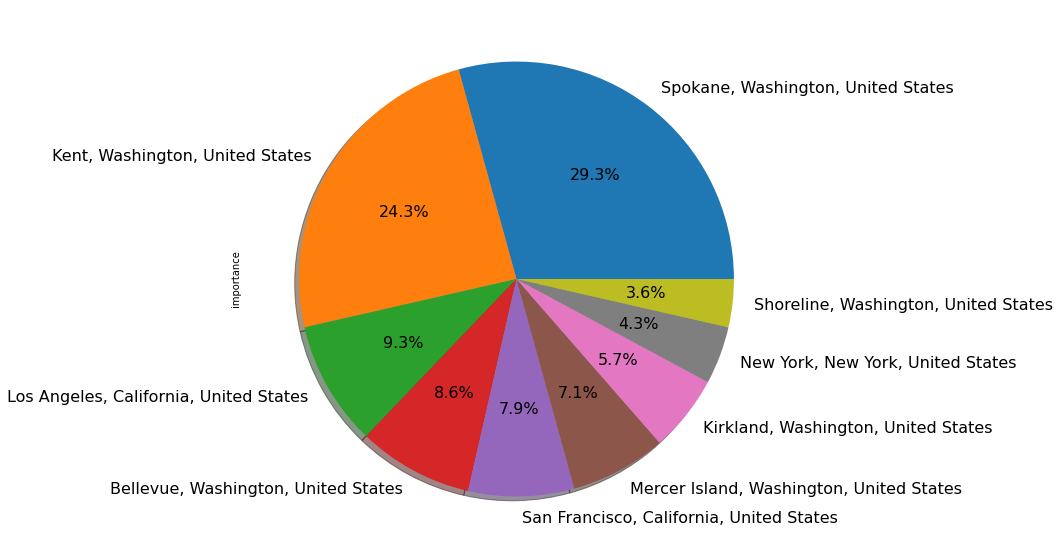

# ========================================================
# ========================================================

# (Q2) As a place owner in seattle, which renting model should I use to maximize my average profit ? 
### (Q2.a) Should I rent entire place ? rent individual rooms? rent shared rooms ?
### (Q2.b) Should I optmize the price for nightly stay ? weekly stay? monthly stay?
### (Q3.c) Should I allow free cancellation  ?

## (A2) We do not have enough information to answer this question, as we do not have information about whether each specific place was reserved (thus, making profit) at a specific date or not !

# ========================================================
# ========================================================

# Q3) As a tourist who travels alone with low budget and flexibility of free time, (a) which month of the year would be cheapest for me to have a vacation in Seatle ? Also (b) which neighbourhood should I target if I am not so picky ?

## (A3) Looking at this graph, we could see that the cheapest possible option would be Magnolia in January. That would be our recommendation to the tourist.
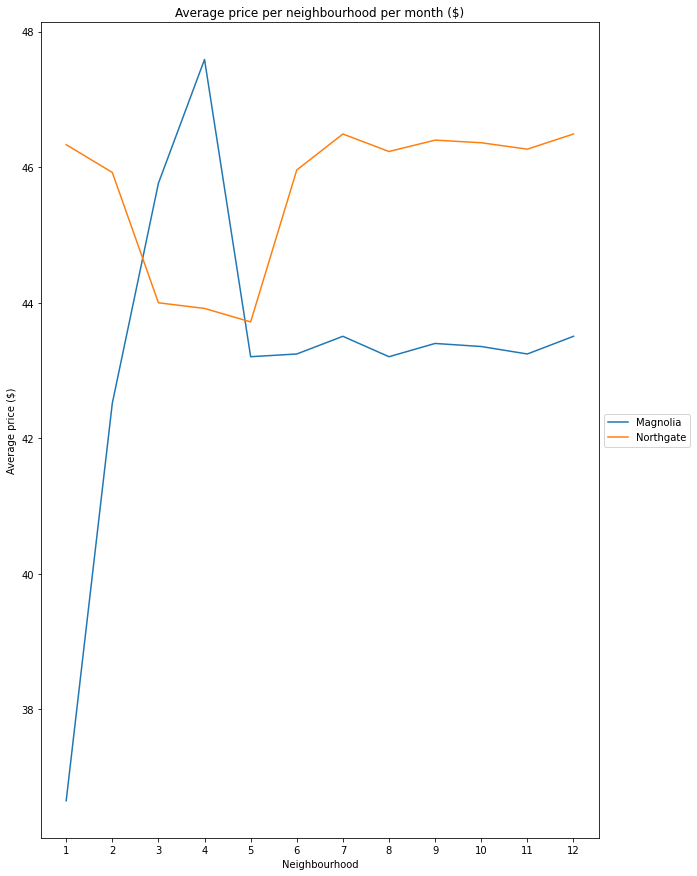

In [742]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense


x0 = Input(shape=(2,))
print(type(x0))
x1 = Dense(2)(x0)
model = Model(inputs=x0, outputs=x1)



<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>


AttributeError: module 'tensorflow.keras' has no attribute 'KerasTensor'